<a href="https://colab.research.google.com/github/YoavKurtz/ObjDetectChallenge/blob/main/TrainFasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import typing
import os

# Verify that we are running on GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
assert torch.cuda.is_available()

# Prepare data

In [32]:
# Clone the repo so we'll have access to the data

!git clone https://github.com/YoavKurtz/ObjDetectChallenge.git

fatal: destination path 'ObjDetectChallenge' already exists and is not an empty directory.


In [56]:
%cd ObjDetectChallenge/
!git pull
%cd ..

/content/ObjDetectChallenge
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/YoavKurtz/ObjDetectChallenge
   70c4804..eb0cd41  main       -> origin/main
Updating 70c4804..eb0cd41
Fast-forward
 Models/FasterRCNN.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)
/content


In [54]:
!ls ObjDetectChallenge/data/busesTrain/

DSCF1013.JPG  DSCF1044.JPG  DSCF1072.JPG  DSCF1103.JPG	DSCF1130.JPG
DSCF1015.JPG  DSCF1048.JPG  DSCF1074.JPG  DSCF1104.JPG	DSCF1132.JPG
DSCF1016.JPG  DSCF1049.JPG  DSCF1077.JPG  DSCF1105.JPG	DSCF1133.JPG
DSCF1017.JPG  DSCF1050.JPG  DSCF1081.JPG  DSCF1106.JPG	DSCF1135.JPG
DSCF1021.JPG  DSCF1053.JPG  DSCF1082.JPG  DSCF1109.JPG	DSCF1137.JPG
DSCF1023.JPG  DSCF1056.JPG  DSCF1086.JPG  DSCF1110.JPG	DSCF1140.JPG
DSCF1025.JPG  DSCF1059.JPG  DSCF1088.JPG  DSCF1111.JPG	DSCF1141.JPG
DSCF1029.JPG  DSCF1061.JPG  DSCF1090.JPG  DSCF1114.JPG	DSCF1142.JPG
DSCF1032.JPG  DSCF1064.JPG  DSCF1092.JPG  DSCF1116.JPG	gt_detections.txt
DSCF1037.JPG  DSCF1065.JPG  DSCF1094.JPG  DSCF1120.JPG
DSCF1038.JPG  DSCF1066.JPG  DSCF1097.JPG  DSCF1122.JPG
DSCF1040.JPG  DSCF1068.JPG  DSCF1099.JPG  DSCF1125.JPG
DSCF1042.JPG  DSCF1070.JPG  DSCF1101.JPG  DSCF1129.JPG


Expected layout of the data:
each datapoint is pair of (image, target). target is a dict in the form:
* `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
* `labels` (`Int64Tensor[N]`): the label for each bounding box
* `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
* `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
* `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.

In [55]:
from PIL import Image
import ast

class ToyBusDataset(torch.utils.data.Dataset):
  def __init__(self, data_folder, gt_file_name, transforms=None):
    self.data_folder = data_folder
    self.transforms = transforms
    # load all files in dir (annotations and images)
    file_list = list(os.listdir(data_folder))
    self.imgs = [f for f in file_list if f.endswith('.JPG')]
   
    self.annotations_dict = {}
    bboxFile = os.path.join(data_folder, gt_file_name)
    with open(bboxFile) as f:
      lines = f.readlines()
      for line in lines:
        img_name, boxes = line.split(':')
        boxes_parsed = ast.literal_eval(boxes)
        # ast.literal_eval returns a tuple of lists if #boxes > 1, otherwise it returns a single list
        # we want that annotations_dict will hold lists that we can loop across (even if there's only one box),
        # so we make sure that it holds a list of lists.
        self.annotations_dict[str(img_name)] = list(boxes_parsed) if isinstance(boxes_parsed, tuple) else [boxes_parsed]

  def __getitem__(self, idx):
    # load image
    img_path = os.path.join(self.data_folder, self.imgs[idx])
    img = Image.open(img_path).convert("RGB") 

    boxes = []
    labels = []
    area = []

    annotations = self.annotations_dict[self.imgs[idx]]
    num_boxes = len(annotations)
    for anno in annotations:
      w, h = anno[2:4]
      boxes.append([anno[0], anno[1], anno[0] + w, anno[1] + h])
      labels.append(anno[4])
      area.append(w * h)
    
    target = {}
    target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)
    target['labels'] = torch.as_tensor(labels, dtype=torch.int64)
    target['image_id'] = torch.tensor([idx])
    target['area'] = torch.as_tensor(area, dtype=torch.float32)
    target['iscrowd'] = torch.zeros((num_boxes, ), dtype=torch.int64)

    if self.transforms is not None:
      img, target = self.transforms(img, target)  

    return img, target

  def __len__(self):
    return len(self.imgs)

  def getImgName(self, indx):
    return self.imgs[indx]

# Create data loaders

In [91]:
import ObjDetectChallenge.utils.TorchTrainUtils.transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms)

In [103]:
import ObjDetectChallenge.utils.TorchTrainUtils.utils as refUtils

# set batch size
batch_size = 2

# use our dataset and defined transformations
dataset = ToyBusDataset('ObjDetectChallenge/data/busesTrain/', 'gt_detections.txt', get_transform(train=True))
dataset_test = ToyBusDataset('ObjDetectChallenge/data/busesTrain/', 'gt_detections.txt', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-10])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-10:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=4,
    collate_fn=refUtils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=refUtils.collate_fn)

## See some data

In [26]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import matplotlib.patches as patches

def draw_boxes(img_np, boxes):
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))

  for box in boxes:
    # Create a Rectangle patch
    rect = patches.Rectangle((box[0], box[1]),box[2] - box[0], box[3] - box[1], linewidth=3,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

  ax.set_axis_off()
  ax.imshow(img_np)
  plt.show()

In [ ]:
data_iter = iter(data_loader)
x, y = next(data_iter)
print(x)
print(y)
image_np = x[0].detach().numpy()
image_np = np.transpose(image_np, (1, 2, 0))
boxes = y[0]['boxes'].numpy().astype(np.int32)
draw_boxes(image_np, boxes)

In [ ]:
data_iter = iter(data_loader_test)
x, y = next(data_iter)
image_np = x[0].detach().numpy()
image_np = np.transpose(image_np, (1, 2, 0))
boxes = y[0]['boxes'].numpy().astype(np.int32)
draw_boxes(image_np, boxes)

# Create model instance

## hyper-params

In [94]:
lr = 0.005
momentum = 0.9
weight_decay=0.0005

lr_decay_gamma = 0.1
lr_decay_step_size = 3

max_num_predictions = 100 # max umber of objects we assume can be in the image
score_thresh = 0.05 # any box with score less than threshold will be discarded.

In [79]:
from ObjDetectChallenge.Models.FasterRCNN import MyFasterRCNNModel, BackBone

num_classes = 6 + 1 # 6 colors + background class
model_container = MyFasterRCNNModel(num_classes=num_classes, 
                          backbone_type=BackBone.RESNET_50, 
                          max_num_predictions=max_num_predictions, score_thresh=0.05, verbose=True)


Creating Faster-RCNN model. #classes (including background) = 7 ,Backbone = BackBone.RESNET_50, max number of predicitons = 100


# Train

In [95]:
# construct an optimizer
params = [p for p in model_container.model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr,
                            momentum=momentum, weight_decay=weight_decay)
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=lr_decay_step_size,
                                               gamma=lr_decay_gamma)

In [81]:
num_epochs = 10
model_container.train(num_epochs=num_epochs, optimizer=optimizer, train_loader=data_loader,
                      test_loader=data_loader_test, lr_scheduler=lr_scheduler)

Epoch: [0]  [ 0/25]  eta: 0:01:32  lr: 0.000043  loss: 2.5499 (2.5499)  loss_classifier: 2.3664 (2.3664)  loss_box_reg: 0.1643 (0.1643)  loss_objectness: 0.0164 (0.0164)  loss_rpn_box_reg: 0.0027 (0.0027)  time: 3.7176  data: 2.8085  max mem: 5147
Epoch: [0]  [10/25]  eta: 0:00:27  lr: 0.000459  loss: 2.3428 (2.0192)  loss_classifier: 2.0372 (1.7420)  loss_box_reg: 0.2487 (0.2609)  loss_objectness: 0.0085 (0.0142)  loss_rpn_box_reg: 0.0015 (0.0021)  time: 1.8561  data: 1.0813  max mem: 5147
Epoch: [0]  [20/25]  eta: 0:00:07  lr: 0.000875  loss: 0.8073 (1.3208)  loss_classifier: 0.5271 (1.0743)  loss_box_reg: 0.2126 (0.2355)  loss_objectness: 0.0036 (0.0093)  loss_rpn_box_reg: 0.0012 (0.0017)  time: 1.4178  data: 0.6590  max mem: 5147
Epoch: [0]  [24/25]  eta: 0:00:01  lr: 0.001000  loss: 0.5814 (1.1892)  loss_classifier: 0.3650 (0.9475)  loss_box_reg: 0.2033 (0.2310)  loss_objectness: 0.0038 (0.0091)  loss_rpn_box_reg: 0.0011 (0.0016)  time: 1.1542  data: 0.4371  max mem: 5147
Epoch: [

Iteration #10 loss: 0.32532793283462524
Epoch #0 loss: 0.4134032485576776
Iteration #20 loss: 0.27884024381637573
Epoch #1 loss: 0.3660016105725215
Iteration #30 loss: 0.28217726945877075
Epoch #2 loss: 0.27753072862441724
Iteration #40 loss: 0.43481242656707764
Iteration #50 loss: 0.2024386078119278
Epoch #3 loss: 0.2305748680463204
Iteration #60 loss: 0.19925619661808014
Epoch #4 loss: 0.20919922624643034


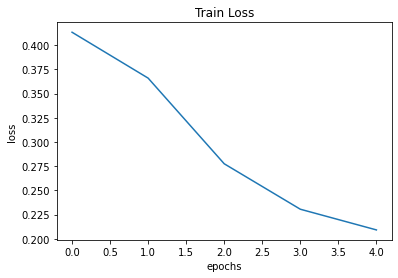

In [96]:
# Simpler training loop
num_epochs =  5
itr = 1
total_train_loss = []
total_val_loss = []

model_container.model.train()
for epoch in range(num_epochs):
  train_loss = []
  for images, targets in data_loader:
       
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = model_container.model(images, targets)

    losses = sum(loss for loss in loss_dict.values())
    loss_value = losses.item()
    train_loss.append(loss_value)

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    if itr % 10 == 0:
      print(f"Iteration #{itr} loss: {loss_value}")

    itr += 1
    
  # update the learning rate
  if lr_scheduler is not None:
    lr_scheduler.step()

  epoch_train_loss = np.mean(train_loss)
  total_train_loss.append(epoch_train_loss)
  print(f"Epoch #{epoch} loss: {epoch_train_loss}")   

plt.title('Train Loss')
plt.plot(total_train_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [97]:
data_iter = iter(data_loader)

In [1]:
x,y = next(data_iter)
image_np = x[0].detach().numpy()
image_np = np.transpose(image_np, (1, 2, 0))
boxes = y[0]['boxes'].numpy().astype(np.int32)
draw_boxes(image_np, boxes)

NameError: ignored

In [111]:
test_iter = iter(data_loader_test)

In [123]:
x, y = next(test_iter)
image_np = np.transpose(x[0].detach().numpy(), (1, 2, 0))
print(y)

({'boxes': tensor([[2399.,  358., 3210.,  877.],
        [ 585.,  740., 1512., 1319.]]), 'labels': tensor([3, 2]), 'image_id': tensor([31]), 'area': tensor([420909., 536733.]), 'iscrowd': tensor([0, 0])},)


# Tests
--------


In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, min_size=800,
                                                                         box_score_thresh=0.5,
                                                                         box_detections_per_img=max_num_predictions,)
# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 7)
model.to(device)

--2020-12-25 12:22:26--  https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.0.155, 151.101.64.155, 151.101.128.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.0.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2178423 (2.1M) [image/jpeg]
Saving to: ‘car.jpg’

car.jpg             100%[===================>]   2.08M  --.-KB/s    in 0.03s   

2020-12-25 12:22:26 (61.8 MB/s) - ‘car.jpg’ saved [2178423/2178423]

torch.Size([3, 2139, 3500])


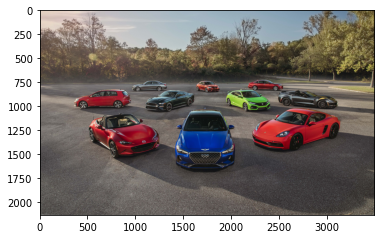

In [44]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
!wget https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg -O car.jpg
im = np.array(Image.open('car.jpg'))
plt.imshow(im)

transform = T.Compose([T.ToTensor()]) 

im_torch =transform(im).to(device)
#im_torch = im_torch.permute(2, 0, 1)
print(im_torch.shape)

In [124]:
model_container.model.eval()
with torch.no_grad():
  predictions = model_container.model([x[0].to(device)])
print(predictions)

[{'boxes': tensor([[ 591.2806,  757.6547, 1495.6514, 1285.6322],
        [2364.3210,  351.0397, 3207.1233,  881.7816],
        [ 623.4171,  831.7245, 1584.9763, 1342.6948],
        [2375.5630,  362.5045, 3223.9954,  893.8710],
        [2388.8857,  364.9447, 3212.4790,  878.1520],
        [ 611.2141,  747.8156, 1496.0551, 1306.3209],
        [2386.1475,  365.2528, 3207.4167,  848.0579],
        [2379.5701,  393.0452, 3224.6479,  856.5482],
        [ 598.0959,  784.0276, 1490.7463, 1319.4700],
        [2383.6816,  359.7326, 3199.4143,  865.3683],
        [ 583.9894,  761.8625, 1499.2533, 1326.0522],
        [ 948.5887, 1378.3975, 2285.0723, 1959.8346],
        [ 984.5010, 1354.2529, 2382.6758, 1971.4683],
        [ 558.1874,  756.2103, 1514.3367, 1304.2844],
        [1600.0350, 1399.7455, 2317.6182, 1892.8417],
        [1002.6669, 1260.1093, 2524.0930, 1956.6560],
        [1604.8475, 1404.8657, 2336.3330, 1889.3380],
        [1618.8489, 1416.9221, 2315.7693, 1886.1926],
        [1029.867

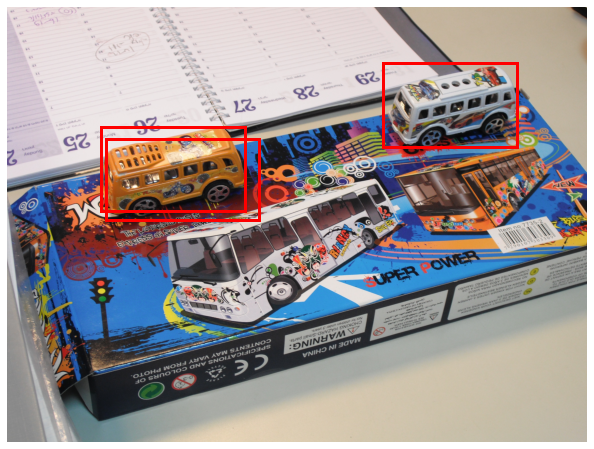

In [127]:
boxes = predictions[0]['boxes'].detach().cpu().numpy()
draw_boxes(image_np, [boxes[0], boxes[1], boxes[2]])
